In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
from itertools import combinations
import collections
import pickle

In [107]:
class UCBPolicy:
    def __init__(self, K):
        self.K=K
        self.counts = np.zeros(K, dtype=int)     # Number of times each arm has been pulled
        self.values = np.zeros(K, dtype=float)   # Empirical means of each arm
        self.total_time = 0                      # Global time step

    def select_arm(self):
        self.total_time += 1
        t = self.total_time

        if t <= self.K:
            # Force one pull per arm in the first K rounds
            return t - 1

        # UCB1 formula assuming known variance = 1
        ucb_values = self.values + np.sqrt(2 * np.log(t) / (self.counts + 1e-8))
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        """Update empirical mean of selected arm with new reward."""
        self.counts[arm] += 1
        n = self.counts[arm]
        old_mean = self.values[arm]
        self.values[arm] = old_mean + (reward - old_mean) / n

    def get_estimates(self):
        return self.values

    def get_counts(self):
        return self.counts

In [108]:
class GaussianTS:
    def __init__(self, n_arms, known_variance=1.0):
        self.n_arms = n_arms
        self.prior_mean = np.zeros(n_arms)
        self.prior_precision = np.ones(n_arms) * 1e-6  # Start with vague prior
        self.known_variance = known_variance

    def select_arm(self):
        sampled_means = np.random.normal(
            self.prior_mean,
            np.sqrt(self.known_variance / self.prior_precision)
        )
        return np.argmax(sampled_means)

    def update(self, arm, reward):
        self.prior_precision[arm] += 1
        self.prior_mean[arm] += (reward - self.prior_mean[arm]) / self.prior_precision[arm]

In [109]:
class GPfunctions:
    def __init__(self, K, length_scale=None, IfStationary=True):
        self.K=K
        self.num_points= 15 #number of actions
        actionspace =  np.linspace(0,2,self.num_points) #.reshape(-1, 1) # grid points
        self.actionspace = np.sort(actionspace,axis=0)
        self.length_scale=length_scale
        # Compute covariance matrix
        if IfStationary == True:
            self.kernel = self.rbf_kernel()
        else:
            self.kernel = self.gibbs_kernel()
        self.subset = self.algorithm()
        self.geneate_combinations()
    
    def geneate_combinations(self):
        # Generate all K-action combinations
        all_combinations = list(combinations(range(self.num_points), self.K))
        # Create both dictionaries
        self.combination_index = {comb: idx for idx, comb in enumerate(all_combinations)}
        self.index_combination = {idx: comb for idx, comb in enumerate(all_combinations)}
        # # Example usage:
        # example_comb = (0, 1, 2, 3, 4)
        # example_idx = 1234
        
    # Stationary Gaussian Kernel
    def rbf_kernel(self):
        """Computes the RBF kernel matrix."""
        actionset=self.actionspace.reshape((-1,1))
        sq_dist = cdist(actionset,actionset, 'sqeuclidean')
        return np.exp(-sq_dist / (2 * self.length_scale ** 2))
    
    # Non-stationary Gibbs Kernel
    def gibbs_kernel(self):
        """Computes the Gibbs kernel matrix."""
        K = np.zeros((self.num_points,self.num_points))
        # Compute the kernel matrix
        for i in range(self.num_points):
            for j in range(self.num_points):
                K[i,j] = self.gibbs_kernel_fun(self.actionspace[i],self.actionspace[j])
        return K

    # Define an input-dependent length scale function l(x)
    def length_scale_fun(self, x):
        return 0.1 + 0.9* np.exp(-x**2)  # Short length scale near 0, longer away

    # Define the 1D Gibbs kernel function
    def gibbs_kernel_fun(self, x, x_prime):
        l_x = self.length_scale_fun(x)
        l_xp = self.length_scale_fun(x_prime)
        numerator = 2 * l_x * l_xp
        denominator = l_x**2 + l_xp**2
        prefactor = np.sqrt(numerator / denominator)
        exponent = - (x - x_prime)**2 / denominator
        return prefactor * np.exp(exponent)

    def samples(self,size):
        # Sample multiple functions from the GP
        return np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel,size=size)

    def algorithm(self):
        # Sample multiple functions from the GP
        f_samples = self.samples(size=self.K)
        # Find the max index for each batch
        max_indices = np.argmax(f_samples, axis=1)  # Shape: (num_batches,)
        # Get unique max indices
        subset = np.unique(max_indices)
        while len(subset) < self.K: # add more items until K distinct actions are found
            f_samples = self.samples(size=self.K-len(subset))
            max_indices = np.argmax(f_samples, axis=1)
            subset = np.unique(np.append(subset,max_indices))
        # print("Unique actions:", subset)
        return list(subset)
    
    def test(self,subset):
        num_batches = 10**5  # Number of function samples for testing
        # Sample multiple functions from the GP
        f_samples = self.samples(size=num_batches) # np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel, size=num_batches)
        return np.average(np.max(f_samples, axis=1)-np.max(f_samples[:,subset], axis=1))

    def run_ucb(self, time_steps=3000):
        bandit = UCBPolicy(len(self.combination_index))
        rewards = []
        for t in range(time_steps+len(self.combination_index)): #the initialization doesn't include
            arm = bandit.select_arm()
            selected_actions = list(self.index_combination[arm])
            # if t>len(self.combination_index):
            #     print(selected_actions)
            f_samples = self.samples(size=1).reshape(-1)
            reward = np.max(f_samples[selected_actions])
            bandit.update(arm, reward)
            rewards.append(reward)
        return selected_actions
    
    def run_ts(self, time_steps=3000):
        bandit = GaussianTS(len(self.combination_index), known_variance=1)
        rewards = []
        for _ in range(time_steps):
            arm = bandit.select_arm()
            selected_actions = list(self.index_combination[arm])
            # print(selected_actions)
            f_samples = self.samples(size=1).reshape(-1)
            reward = np.max(f_samples[selected_actions]) #np.max(f_samples)-
            bandit.update(arm, reward)
            rewards.append(reward)
        # print("Estimated means:", bandit.prior_mean)
        return selected_actions

In [86]:
report.to_csv('report15.csv',index=None)

In [85]:
IfStationary=True
report=pd.DataFrame(columns=['EmpiricialRegret','length_scale','K','method'])
length_range=[0.5,1,1.5,2,2.5,3,4] 
K=5
for length_scale in length_range:
    for ignore in range(50):
        fun=GPfunctions(K,length_scale=length_scale,IfStationary=IfStationary)
        output=fun.test(fun.subset)
        ucb=fun.test(fun.run_ucb(time_steps=3000))
        ts=fun.test(fun.run_ts(time_steps=3000))
        row=pd.Series({'EmpiricialRegret':output,'length_scale':length_scale,'K':K,'method':'epsilon'})
        row_ucb=pd.Series({'EmpiricialRegret':ucb,'length_scale':length_scale,'K':K,'method':'ucb'})
        row_ts=pd.Series({'EmpiricialRegret':ts,'length_scale':length_scale,'K':K,'method':'ts'})
        report = pd.concat([report,row.to_frame().T,row_ucb.to_frame().T,row_ts.to_frame().T], ignore_index=True)

In [ ]:
batch_size=50

length_scale=1
eps_counts = collections.Counter()
for igonore in range(50):
    fun=GPfunctions(K,length_scale=length_scale,IfStationary=True)
    eps_counts.update(fun.subset)

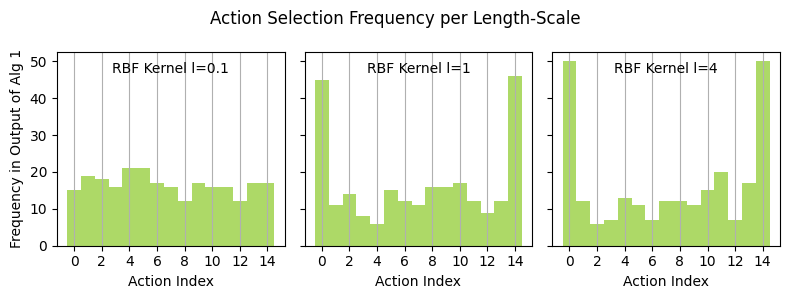

In [105]:
fig, axes = plt.subplots(1,3,figsize=(8,3),sharey=True,sharex=True)  # (rows, cols)
methods = ['Epsilon','ts','ucb']
colormap = dict(zip(methods, ['#8ac926','#ffca3a','#ff595e']))
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
num_points=15
bin_size=1
K=5
length_scale_range=[0.1,1,4]

for i in range(3):
    eps_counts = collections.Counter()
    for igonore in range(50):
        fun=GPfunctions(K,length_scale=length_scale_range[i],IfStationary=True)
        eps_counts.update(fun.subset)
    axes[i].bar([*range(num_points)], [eps_counts[j] for j in range(num_points)], width=bin_size,alpha=0.7,color=colormap[methods[0]])
    # axes[i].set_xlabel('Action Space with Cardinality {}'.format(num_points))
    axes[i].set_xlabel('Action Index')
    axes[i].set_xticks([*range(0,num_points,2)])
    axes[i].set_xticklabels([*range(0,num_points,2)])
    axes[i].grid(True, axis='x')
    # axes[i].set_title(f'RBF Kernel l={length_scale_range[i]}')
    axes[i].text(7,48, 'RBF Kernel l={}'.format(length_scale_range[i]), horizontalalignment='center',verticalalignment='center')
    if i == 0:
        axes[i].set_ylabel('Frequency in Output of Alg 1')
    # axes[i].set_title('{}'.format(methodnames[methods[i]]))

plt.suptitle("Action Selection Frequency per Length-Scale")

# i=3
# fun=GPfunctions(K,length_scale=1,IfStationary=True)
# fun_samples=fun.samples(size=5)
# for j in range(5):
#     axes[i].plot([*range(fun.num_points)],fun_samples[j,:],color='#1982c4')
# axes[i].set_xlabel('Action Index')
# axes[i].set_ylabel(r'Expected Outcome $\mu_a$')

# # axes[i].set_ylim([-0.05,0.5])
# axes[i].set_title('Example Outcome Function\n RBF Kernel l={}'.format(length_scale)) #"K={} out of 15 Actions".format(krange[i])

# # Move the left spine (axis line) to the right
# axes[i].yaxis.tick_right()  # Move ticks to the right
# axes[i].yaxis.set_label_position("right")  # Move the label to the right

# Save plot as a PDF without margins
plt.savefig("frequency_length.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

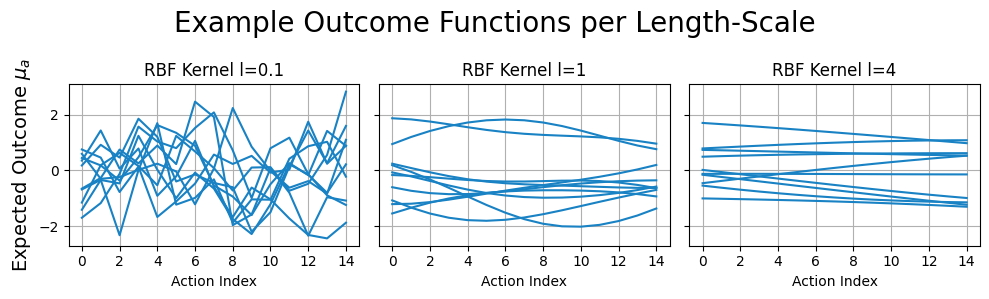

In [121]:
num_points=15
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
batch_size=10
for idx, length_scale in enumerate([0.1,1, 4]):
    fun = GPfunctions(1, length_scale=length_scale, IfStationary=True)
    fun_samples = fun.samples(size=batch_size)
    
    ax = axes[idx]
    for i in range(batch_size):
        ax.plot(range(fun.num_points), fun_samples[i, :], color='#1982c4')
    
    ax.set_xticks([*range(0,num_points,2)])
    ax.set_xticklabels([*range(0,num_points,2)])
    ax.set_xlabel('Action Index')
    ax.set_title(f'RBF Kernel l={length_scale}')
    ax.grid(True)

axes[0].set_ylabel(r'Expected Outcome $\mu_a$',fontsize=14)
plt.suptitle("Example Outcome Functions per Length-Scale",fontsize=20)

plt.tight_layout()
plt.savefig("RBF_comparison.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

In [14]:
batch_size=50
K=5
length_scale=1
eps_counts = collections.Counter()
ts_counts  = collections.Counter()
ucb_counts = collections.Counter()
for igonore in range(batch_size):
    fun=GPfunctions(K,length_scale=length_scale,IfStationary=True)
    eps_counts.update(fun.subset)
    ts_counts.update(fun.run_ts(time_steps=3000))
    ucb_counts.update(fun.run_ucb(time_steps=3000))

# Save the counters
with open("counts{}.pkl".format(length_scale), "wb") as f:
    pickle.dump({
        "eps_counts": eps_counts,
        "ts_counts": ts_counts,
        "ucb_counts": ucb_counts
    }, f)

In [27]:
length_scale=1
with open("counts{}.pkl".format(length_scale), "rb") as f:
    data = pickle.load(f)
    eps_counts = data["eps_counts"]
    ts_counts = data["ts_counts"]
    ucb_counts = data["ucb_counts"]

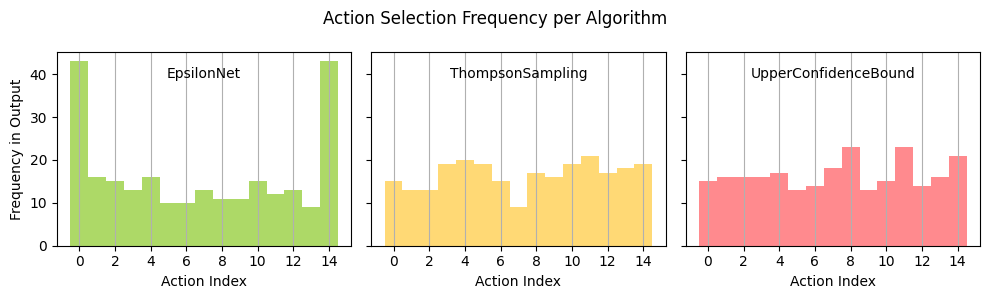

In [59]:
fig, axes = plt.subplots(1,3,figsize=(10,3),sharey=True,sharex=True)  # (rows, cols)
methods = ['Epsilon','ts','ucb']
colormap = dict(zip(methods, ['#8ac926','#ffca3a','#ff595e']))
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
num_points=15
bin_size=1

i=0
axes[i].bar([*range(num_points)], [eps_counts[j] for j in range(num_points)], width=bin_size,alpha=0.7,color=colormap[methods[i]])
i=1
axes[i].bar([*range(num_points)], [ts_counts[j] for j in range(num_points)], width=bin_size,alpha=0.7,color=colormap[methods[i]])
i=2
axes[i].bar([*range(num_points)], [ucb_counts[j] for j in range(num_points)], width=bin_size,alpha=0.7,color=colormap[methods[i]])

for i in range(3):
    # axes[i].set_xlabel('Action Space with Cardinality {}'.format(num_points))
    axes[i].set_xlabel('Action Index')
    axes[i].set_xticks([*range(0,num_points,2)])
    axes[i].set_xticklabels([*range(0,num_points,2)])
    axes[i].grid(True, axis='x')
    axes[i].text(7,40, methodnames[methods[i]], horizontalalignment='center',verticalalignment='center')
    if i == 0:
        axes[i].set_ylabel('Frequency in Output')
    # axes[i].set_title('{}'.format(methodnames[methods[i]]))

plt.suptitle("Action Selection Frequency per Algorithm")

# i=3
# fun=GPfunctions(K,length_scale=1,IfStationary=True)
# fun_samples=fun.samples(size=5)
# for j in range(5):
#     axes[i].plot([*range(fun.num_points)],fun_samples[j,:],color='#1982c4')
# axes[i].set_xlabel('Action Index')
# axes[i].set_ylabel(r'Expected Outcome $\mu_a$')

# # axes[i].set_ylim([-0.05,0.5])
# axes[i].set_title('Example Outcome Function\n RBF Kernel l={}'.format(length_scale)) #"K={} out of 15 Actions".format(krange[i])

# # Move the left spine (axis line) to the right
# axes[i].yaxis.tick_right()  # Move ticks to the right
# axes[i].yaxis.set_label_position("right")  # Move the label to the right

# Save plot as a PDF without margins
plt.savefig("frequency{}.pdf".format(length_scale), format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

In [122]:
K=5
length_scale=3
fun=GPfunctions(K,length_scale=length_scale,IfStationary=True)
eps_points = fun.subset              # e.g., [1, 5, 8, 10, 14]
ts_points = fun.run_ucb(time_steps=100)   # e.g., [0, 4, 7, 12, 13]
ucb_points = fun.run_ucb(time_steps=10000) # e.g., [2, 3, 6, 9, 15]

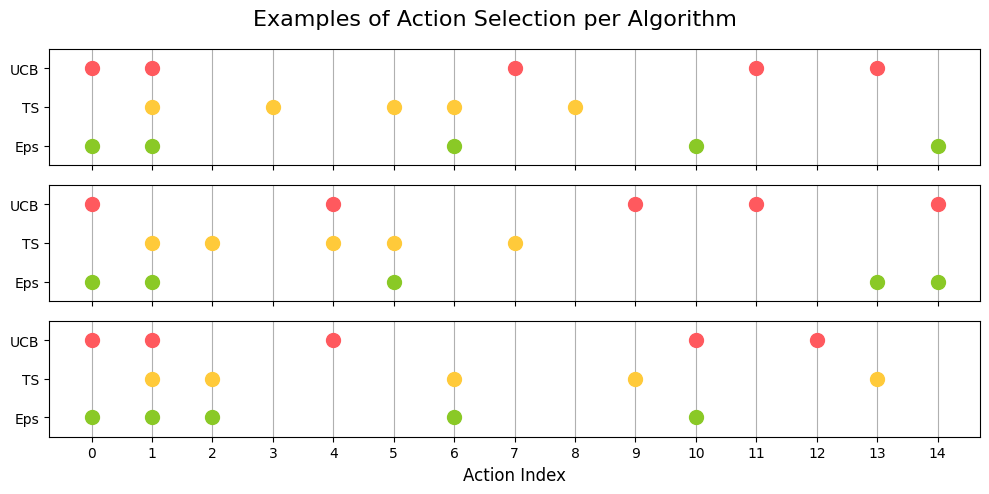

In [126]:
batch_size = 3
num_points = 15  # Total number of possible actions
K=5 # subset set
length_scale=1
fig, axs = plt.subplots(batch_size, 1, figsize=(10,5), sharex=True)

for i in range(batch_size):
        fun=GPfunctions(K,length_scale=length_scale,IfStationary=True)
        eps_points = fun.subset              # e.g., [1, 5, 8, 10, 14]
        ts_points = fun.run_ts(time_steps=3000)   # e.g., [0, 4, 7, 12, 13]
        ucb_points = fun.run_ucb(time_steps=3000) # e.g., [2, 3, 6, 9, 15]

        ax = axs[i]
        ax.plot(eps_points, [1]*K, marker='o', markersize=10,
                linestyle='None', color='#8ac926', label='Our')
        ax.plot(ts_points, [2]*K, marker='o', markersize=10,
                linestyle='None', color='#ffca3a', label='TS')
        ax.plot(ucb_points, [3]*K, marker='o', markersize=10,
                linestyle='None', color='#ff595e', label='UCB')

        ax.set_yticks([1, 2, 3])
        ax.set_yticklabels(['Eps', 'TS', 'UCB'])
        ax.set_ylim(0.5, 3.5)
        ax.grid(True, axis='x')
        # ax.set_title(f"Run {i+1}")
# axs[0].set_title("Examples of Action Selection per Algorithm")
plt.suptitle("Examples of Action Selection per Algorithm",fontsize=16)
axs[-1].set_xlabel('Action Index',fontsize=12)
axs[-1].set_xticks(range(num_points))
plt.tight_layout()
# Save plot as a PDF without margins
plt.savefig("frequency_example.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

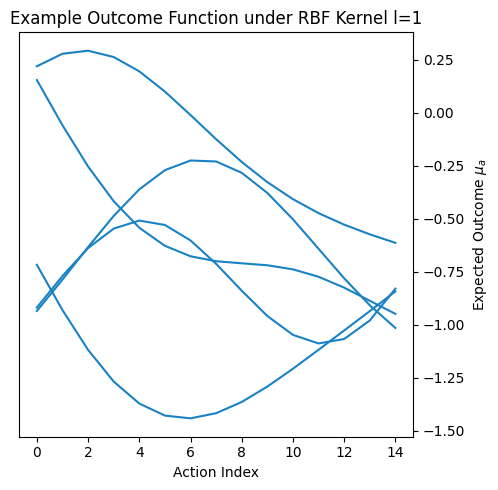

In [64]:
length_scale=1
fun=GPfunctions(K,length_scale=1,IfStationary=True)
fun_samples=fun.samples(size=5)

fig, ax = plt.subplots(figsize=(5,5))
for i in range(5):
    plt.plot([*range(fun.num_points)],fun_samples[i,:],color='#1982c4')
plt.xlabel('Action Index')
plt.ylabel(r'Expected Outcome $\mu_a$')

# axes[i].set_ylim([-0.05,0.5])
plt.title('Example Outcome Function under RBF Kernel l={}'.format(length_scale)) #"K={} out of 15 Actions".format(krange[i])

# Move the left spine (axis line) to the right
ax.yaxis.tick_right()  # Move ticks to the right
ax.yaxis.set_label_position("right")  # Move the label to the right

plt.tight_layout()
# Save plot as a PDF without margins
plt.savefig("RBF_example.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

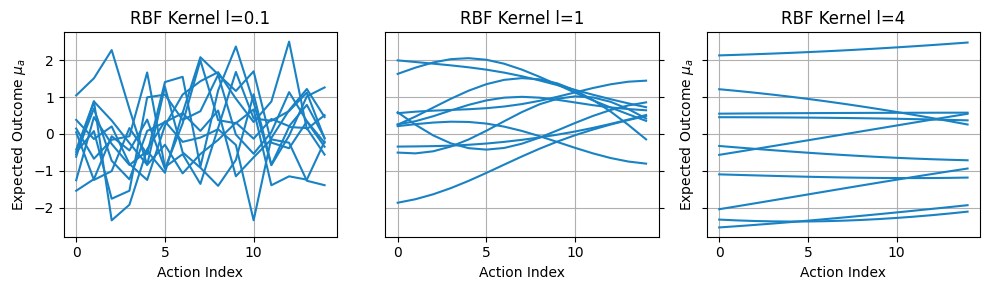

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
batch_size=10
for idx, length_scale in enumerate([0.1,1, 4]):
    fun = GPfunctions(1, length_scale=length_scale, IfStationary=True)
    fun_samples = fun.samples(size=batch_size)
    
    ax = axes[idx]
    for i in range(batch_size):
        ax.plot(range(fun.num_points), fun_samples[i, :], color='#1982c4')
    
    ax.set_xlabel('Action Index')
    if idx == 1:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
    else:
        ax.set_ylabel(r'Expected Outcome $\mu_a$')

    ax.set_title(f'RBF Kernel l={length_scale}')
    ax.grid(True)

plt.tight_layout()
plt.savefig("RBF_comparison.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

**Plots**

In [7]:
report=pd.read_csv('report15.csv')
length_range=[0.5,1,1.5,2,2.5,3,4] 

In [89]:
num_points=1000
gibbs=gibbsmatrix(num_points=num_points)
actionspace=gibbs.actionspace
kernel=gibbs.kernel

In [90]:
batch_size=5000
all_counts = collections.Counter()
# Run fun.subset() many times and update the counts
fun=GPfunctions_Epsilon(K=batch_size,actionspace=actionspace,kernel=kernel)
indices = fun.subset  # Should return a subset (e.g., list or set) of indices
all_counts.update(indices)

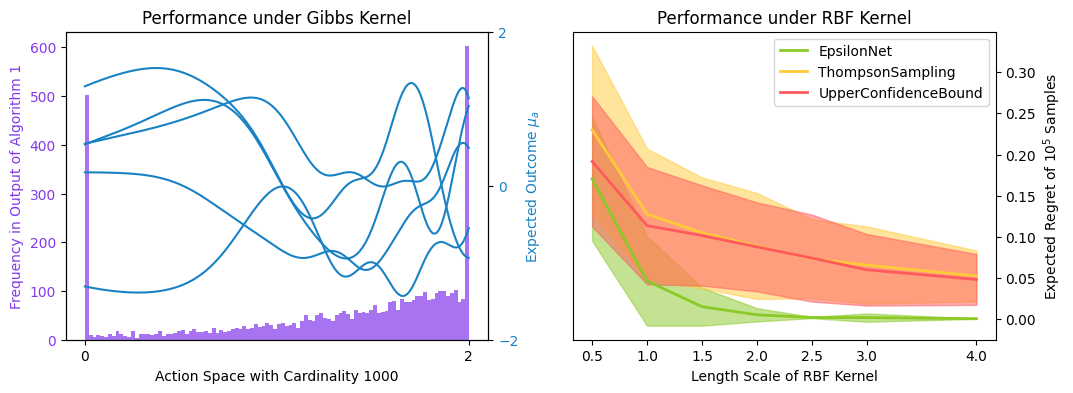

In [92]:
fig, axes = plt.subplots(1,2,figsize=(12,4))  # (rows, cols)
# plt.subplots_adjust(wspace=0.01)
methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
K=5
colormap = dict(zip(methods, ['#8ac926','#ffca3a','#ff595e']))

i=1
for m in methods:
    dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
    mean=np.array([dfmean[l][K][m] for l in length_range])
    dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
    std=np.array([dfstd[l][K][m] for l in length_range])
    axes[i].plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m],linewidth=2)
    axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.5)

# axes[i].set_ylim([-0.05,0.5])
axes[i].set_title('Performance under RBF Kernel') #"K={} out of 15 Actions".format(krange[i])
axes[i].set_xlabel("Length Scale of RBF Kernel")
axes[i].set_xticks(length_range)
axes[i].set_ylabel(r"Expected Regret of $10^5$ Samples")
axes[i].legend()
# Move the left spine (axis line) to the right
axes[i].yaxis.tick_right()  # Move ticks to the right
axes[i].yaxis.set_label_position("right")  # Move the label to the right


i=0
# First plot (left y-axis)
color1 = '#8338ec'

# Group indices into one bin
bin_size = 10
num_bins = num_points // bin_size
grouped_histogram = [sum(all_counts[i] for i in range(b * bin_size, (b + 1) * bin_size)) for b in range(num_bins)]
# Plot the grouped histogram
axes[i].bar([b * bin_size + bin_size/2  for b in range(num_bins)], grouped_histogram, width=bin_size,alpha=0.7,color=color1)
axes[i].set_xlabel('Action Space with Cardinality {}'.format(num_points))
axes[i].set_xticks([0,999])
axes[i].set_xticklabels([0,2])
axes[i].set_ylabel('Frequency in Output of Algorithm 1', color=color1)
axes[i].tick_params(axis='y', labelcolor=color1)
axes[i].set_title('Performance under Gibbs Kernel')

# Second y-axis
ax2 = axes[i].twinx()
color2 = '#1982c4' #"#2a9d8f"
ax2.set_ylabel(r'Expected Outcome $\mu_a$', color=color2)
batch_size=5
fun=GPfunctions_Epsilon(K=1,actionspace=actionspace,kernel=kernel)
fun_samples=fun.samples(size=batch_size)
for i in range(batch_size):
    ax2.plot([*range(num_points)],fun_samples[i,:],color=color2)
ax2.set_yticks([2, 0, -2])  # set the tick positions
ax2.tick_params(axis='y', labelcolor=color2)

# Save plot as a PDF without margins
plt.subplots_adjust(wspace=None)
plt.savefig("RKHS_baselines.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
# plt.tight_layout()
plt.show()

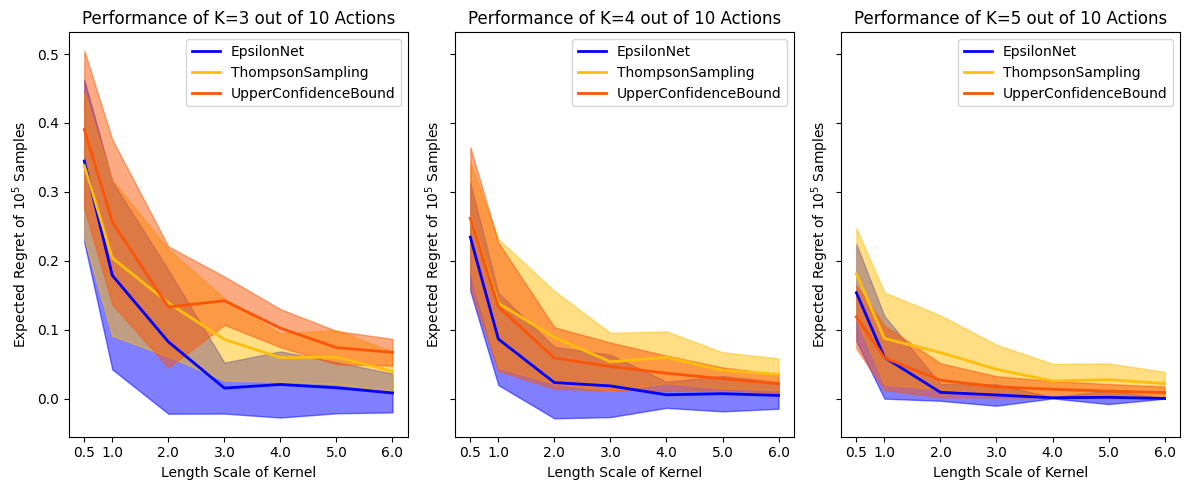

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(12, 5),sharey=True)  # (rows, cols)
methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
krange = [3,4,5]
colormap = dict(zip(methods, ['b','#FFBE0B','#FB5607']))
# length_range=[0.5,1,1.5,2,2.5]
for i in range(3):
    for m in methods:
        dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
        mean=np.array([dfmean[l][krange[i]][m] for l in length_range])
        dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
        std=np.array([dfstd[l][krange[i]][m] for l in length_range])
        axes[i].plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m],linewidth=2)
        axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.5)

    # axes[i].set_ylim([0,0.8])
    axes[i].set_title("Performance of K={} out of 10 Actions".format(krange[i]))
    axes[i].set_xlabel("Length Scale of Kernel")
    axes[i].set_xticks(length_range)
    axes[i].set_ylabel(r"Expected Regret of $10^5$ Samples")
    axes[i].legend()

# Save plot as a PDF without margins
# plt.savefig("RKHS_baselines.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

KeyError: 10

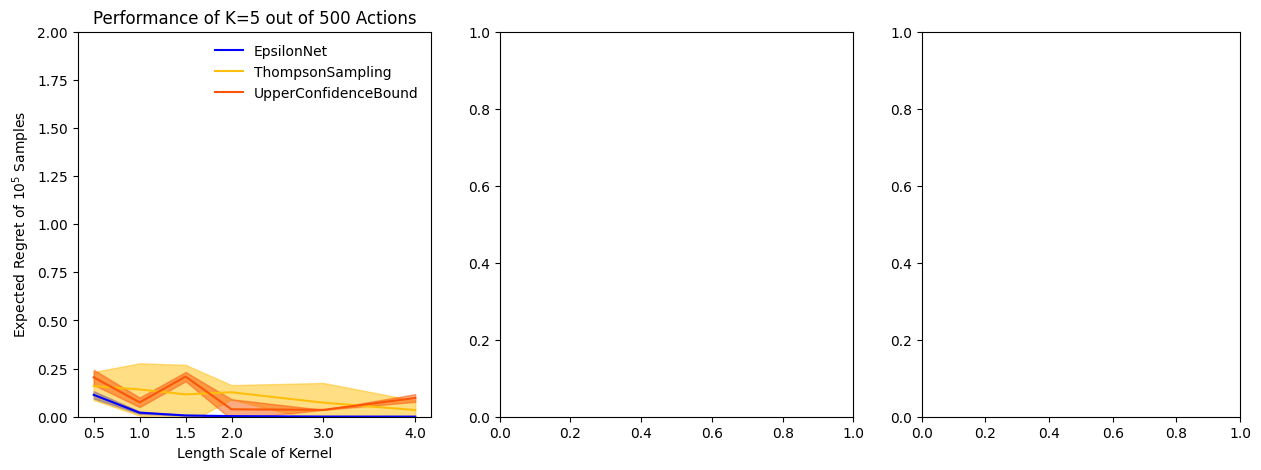

In [41]:
fig, axes = plt.subplots(1,3,figsize=(15, 5), gridspec_kw={'width_ratios': [1,1,0.9]})  # (rows, cols)
# plt.subplots_adjust(wspace=0, hspace=0)
methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
krange = [5,10]
colormap = dict(zip(methods, ['b','#FFBE0B','#FB5607']))
colormap_sample = dict(zip(length_range, ['#DC97FF','#BD68EE','#8B2FC9','#5a108f','#4A0A77','#310055']))

for i in range(2):
    for m in methods:
        dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
        mean=np.array([dfmean[l][krange[i]][m] for l in length_range])
        dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
        std=np.array([dfstd[l][krange[i]][m] for l in length_range])
        axes[i].plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m])
        axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.5)

    axes[i].set_ylim([0,2])
    axes[i].set_title("Performance of K={} out of 500 Actions".format(krange[i]))
    axes[i].set_xlabel("Length Scale of Kernel")
    axes[i].set_xticks(length_range)
    axes[i].set_ylabel(r"Expected Regret of $10^5$ Samples")
    axes[i].legend(frameon=False)

i=2
for l in length_range:
    fun=GPfunctions(1,l)
    axes[i].plot(fun.actionspace,fun.samples(),label="{:.1f}".format(l), color=colormap_sample[l])

axes[i].set_title("Examples of Sampled Functions")
axes[i].set_xlabel("Action Space with Cardinality 500")
axes[i].set_xticks([])
axes[i].set_ylabel(r"Expected Outcome of Actions")
axes[i].legend(title='Length Scale of Kernel',frameon=False)

# Save plot as a PDF without margins
plt.savefig("RKHS_baselines.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

Gibbs

In [40]:
class GPfunctions_Epsilon:
    def __init__(self, K, length_scale=None, actionspace=None, kernel=None):
        self.K=K
        self.length_scale=length_scale
        self.actionspace=actionspace
        self.kernel=kernel
        self.num_points=len(actionspace)
        if len(actionspace)==0:
            self.num_points= 1000 #number of actions
            actionspace =  np.linspace(0,2,self.num_points) #.reshape(-1, 1) # grid points
            self.actionspace = np.sort(actionspace,axis=0)        
            # Compute covariance matrix
            if IfStationary == True:
                self.kernel = self.rbf_kernel()
            else:
                self.kernel = self.gibbs_kernel()
        self.subset = self.algorithm()

    # Stationary Gaussian Kernel
    def rbf_kernel(self):
        """Computes the RBF kernel matrix."""
        actionset=self.actionspace.reshape((-1,1))
        sq_dist = cdist(actionset,actionset, 'sqeuclidean')
        return np.exp(-sq_dist / (2 * self.length_scale ** 2))

    def samples(self,size):
        # Sample multiple functions from the GP
        return np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel,size=size)

    def algorithm(self):
        # Sample multiple functions from the GP
        f_samples = self.samples(size=self.K)
        # Find the max index for each batch
        max_indices = np.argmax(f_samples, axis=1)  # Shape: (num_batches,)
        # Get unique max indices
        # subset = np.unique(max_indices)
        # while len(subset)< self.K: # add more items until K distinct actions are found
        #     f_samples = self.samples(size=self.K-len(subset))
        #     max_indices = np.argmax(f_samples, axis=1)
        #     subset = np.append(subset,np.unique(max_indices))
        # # print("Unique actions:", subset)
        return max_indices

In [39]:
class gibbsmatrix:
    def __init__(self, num_points=1000,length_scale=None):
        self.num_points= num_points#number of actions
        actionspace =  np.linspace(0,2,self.num_points) #.reshape(-1, 1) # grid points
        self.actionspace = np.sort(actionspace,axis=0)        
        # Compute covariance matrix
        self.kernel = self.gibbs_kernel()

    # Non-stationary Gibbs Kernel
    def gibbs_kernel(self):
        """Computes the Gibbs kernel matrix."""
        K = np.zeros((self.num_points,self.num_points))
        # Compute the kernel matrix
        for i in range(self.num_points):
            for j in range(self.num_points):
                K[i,j] = self.gibbs_kernel_fun(self.actionspace[i],self.actionspace[j])
        return K

    # Define an input-dependent length scale function l(x)
    def length_scale_fun(self, x):
        return 0.1 + 0.9* np.exp(-x**2)  # Short length scale near 0, longer away

    # Define the 1D Gibbs kernel function
    def gibbs_kernel_fun(self, x, x_prime):
        l_x = self.length_scale_fun(x)
        l_xp = self.length_scale_fun(x_prime)
        numerator = 2 * l_x * l_xp
        denominator = l_x**2 + l_xp**2
        prefactor = np.sqrt(numerator / denominator)
        exponent = - (x - x_prime)**2 / denominator
        return prefactor * np.exp(exponent)

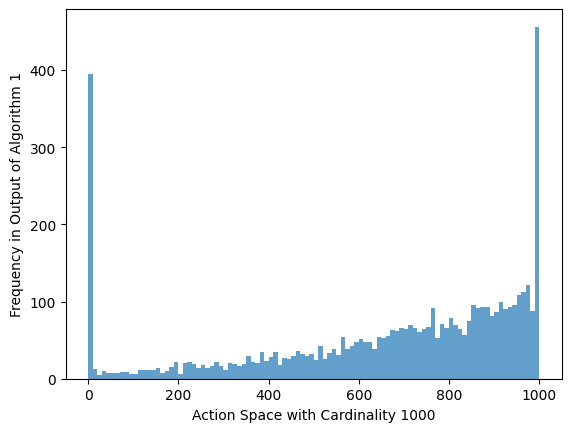

In [40]:
# Group indices into one bin
bin_size = 10
num_bins = num_points // bin_size
grouped_histogram = [sum(all_counts[i] for i in range(b * bin_size, (b + 1) * bin_size)) for b in range(num_bins)]

# Plot the grouped histogram
plt.bar([b * bin_size + bin_size/2  for b in range(num_bins)], grouped_histogram, width=bin_size,alpha=0.7)
plt.xlabel('Action Space with Cardinality 1000')
plt.ylabel('Frequency in Output of Algorithm 1')
# plt.title('Grouped Histogram of Index Appearances in fun.subset')
plt.show()

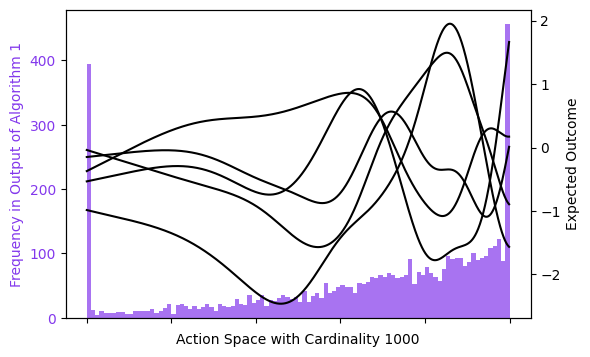

In [57]:
fig, ax = plt.subplots(figsize=(6,4))

# First plot (left y-axis)
color1 = '#8338ec'

# Group indices into one bin
bin_size = 10
num_bins = num_points // bin_size
grouped_histogram = [sum(all_counts[i] for i in range(b * bin_size, (b + 1) * bin_size)) for b in range(num_bins)]
# Plot the grouped histogram
ax.bar([b * bin_size + bin_size/2  for b in range(num_bins)], grouped_histogram, width=bin_size,alpha=0.7,color=color1)
ax.set_xlabel('Action Space with Cardinality {}'.format(num_points))
ax.set_xticklabels([])
ax.set_ylabel('Frequency in Output of Algorithm 1', color=color1)
ax.tick_params(axis='y', labelcolor=color1)

# Second y-axis
ax2 = ax.twinx()
color2 = 'black' #"#2a9d8f"
ax2.set_ylabel('Expected Outcome', color=color2)
batch_size=5
fun=GPfunctions_Epsilon(K=1,actionspace=actionspace,kernel=kernel)
fun_samples=fun.samples(size=batch_size)
for i in range(batch_size):
    ax2.plot([*range(num_points)],fun_samples[i,:],color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# plt.title('Histogram + Line Plot with Two Y Axes')
plt.savefig("Gibbskernel.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()